# 链家租房数据分析

## 数据导入和预处理

### 数据导入

#### 配置数据分析工具

导入numpy, pandas和matplotlib, 配置字体, 行内显示matplotlib图.


In [1]:
import numpy as n
import seaborn as sns
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})

%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Config global font
plt.rcParams['font.sans-serif']='Songti SC'
plt.rcParams['axes.unicode_minus'] =False

#### 导入链家租房数据.


In [2]:
lianjia_data = pd.read_csv("./database/rental.csv")
display(lianjia_data.head(), lianjia_data.shape)


,rental_id,rental_name,rental_url,rental_city,rental_region,rental_business_area,rental_community_url,rental_community,rental_area,rental_lighting,rental_rooms,rental_liverooms,rental_bathrooms,rental_price,rental_timestamp,rental_accessbit
0,1,整租·海语山林 2室2厅 东南,https://sz.lianjia.com/zufang/SZ17043626101466...,深圳,大鹏新区,大鹏半岛,https://sz.lianjia.com/zufang/c2411062673763/,海语山林,69.00,东南,2,2,1,3000,2022-12-26,0
1,2,整租·海语山林 2室2厅 南,https://sz.lianjia.com/zufang/SZ17123504436207...,深圳,大鹏新区,大鹏半岛,https://sz.lianjia.com/zufang/c2411062673763/,海语山林,67.40,南,2,2,1,2700,2022-12-26,0
2,3,整租·海语山林 3室2厅 跃层 南,https://sz.lianjia.com/zufang/SZ16540747918601...,深圳,大鹏新区,大鹏半岛,https://sz.lianjia.com/zufang/c2411062673763/,海语山林,79.00,南,3,2,2,3300,2022-12-26,0
3,4,整租·海语山林 3室2厅 南,https://sz.lianjia.com/zufang/SZ17028886905623...,深圳,大鹏新区,大鹏半岛,https://sz.lianjia.com/zufang/c2411062673763/,海语山林,89.00,南,3,2,2,3300,2022-12-26,0
4,5,整租·海语山林 3室2厅 东南,https://sz.lianjia.com/zufang/SZ15809179083834...,深圳,大鹏新区,大鹏半岛,https://sz.lianjia.com/zufang/c2411062673763/,海语山林,87.16,东南,3,2,2,3500,2022-12-26,0


(170039, 16)

#### 查看数据概况


In [3]:
display(lianjia_data.info(), lianjia_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170039 entries, 0 to 170038
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rental_id             170039 non-null  int64  
 1   rental_name           170039 non-null  object 
 2   rental_url            170039 non-null  object 
 3   rental_city           170039 non-null  object 
 4   rental_region         170039 non-null  object 
 5   rental_business_area  170039 non-null  object 
 6   rental_community_url  170039 non-null  object 
 7   rental_community      170039 non-null  object 
 8   rental_area           170039 non-null  float64
 9   rental_lighting       170039 non-null  object 
 10  rental_rooms          170039 non-null  int64  
 11  rental_liverooms      170039 non-null  int64  
 12  rental_bathrooms      170039 non-null  int64  
 13  rental_price          170039 non-null  int64  
 14  rental_timestamp      170039 non-null  object 
 15  

None

,rental_id,rental_area,rental_rooms,rental_liverooms,rental_bathrooms,rental_price,rental_accessbit
count,170039.000000,170039.000000,170039.000000,170039.000000,170039.000000,170039.000000,170039.0
mean,85020.000000,83.868990,2.366404,1.300478,1.303054,5856.955634,0.0
std,49086.175549,541.967185,1.084734,0.640657,0.611181,7730.758572,0.0
min,1.000000,3.000000,0.000000,0.000000,0.000000,150.000000,0.0
25%,42510.500000,50.000000,2.000000,1.000000,1.000000,2500.000000,0.0
50%,85020.000000,76.000000,2.000000,1.000000,1.000000,4200.000000,0.0
75%,127529.500000,100.000000,3.000000,2.000000,2.000000,6500.000000,0.0
max,170039.000000,201306.000000,20.000000,9.000000,9.000000,450000.000000,0.0


可以看到, 得益于SQLite数据库的not null constraint, 没有null的数据存在.

但是租房面积最小为3平米, 最大为201306平米. 由于房子的宜居面积有推荐值, 所以认为
租房面积为正态分布, 故超出3倍标准差范围的过大面积房屋初步认为是异常值.


#### 字段处理

观察发现, 房屋主键rental_id, 房屋访问位rental_accessbit, 小区url等字段都是用来服
务爬虫的, 对本次数据分析和数据可视化没有作用, 所以去掉.

添加单位面积租金(unit_price)字段, 去掉字段中的lianjia_前缀. 此前缀是用来在数据库中区
分不同表的, 在数据分析中没有用.


In [113]:
df = lianjia_data.copy()

df["unit_price"] = (
    lianjia_data["rental_price"] / lianjia_data["rental_area"]
).round(2)

df.drop(["rental_id"], axis=1, inplace=True)

df = df.rename(
    columns={
        "rental_name": "name",
        "rental_community": "community",
        "rental_business_area": "business_area",
        "rental_region": "region",
        "rental_city": "city",
        "rental_area": "area",
        "rental_price": "price",
        "rental_lighting": "lighting",
        "rental_rooms": "rooms",
        "rental_liverooms": "liverooms",
        "rental_bathrooms": "bathrooms",
    }
)

# Refactor columns
columns = [
    "name",
    "community",
    "business_area",
    "region",
    "city",
    "area",
    "price",
    "unit_price",
    "lighting",
    "rooms",
    "liverooms",
    "bathrooms",
]

df = pd.DataFrame(df, columns=columns)

df = df[~df['region'].isin(['海珠区','南山','宝安'])]

display(df.head(3), df.describe(), df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 170036 entries, 0 to 170038
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           170036 non-null  object 
 1   community      170036 non-null  object 
 2   business_area  170036 non-null  object 
 3   region         170036 non-null  object 
 4   city           170036 non-null  object 
 5   area           170036 non-null  float64
 6   price          170036 non-null  int64  
 7   unit_price     170036 non-null  float64
 8   lighting       170036 non-null  object 
 9   rooms          170036 non-null  int64  
 10  liverooms      170036 non-null  int64  
 11  bathrooms      170036 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 16.9+ MB


,name,community,business_area,region,city,area,price,unit_price,lighting,rooms,liverooms,bathrooms
0,整租·海语山林 2室2厅 东南,海语山林,大鹏半岛,大鹏新区,深圳,69.0,3000,43.48,东南,2,2,1
1,整租·海语山林 2室2厅 南,海语山林,大鹏半岛,大鹏新区,深圳,67.4,2700,40.06,南,2,2,1
2,整租·海语山林 3室2厅 跃层 南,海语山林,大鹏半岛,大鹏新区,深圳,79.0,3300,41.77,南,3,2,2


,area,price,unit_price,rooms,liverooms,bathrooms
count,170036.000000,170036.000000,170036.000000,170036.000000,170036.000000,170036.000000
mean,83.870193,5857.031452,78.047265,2.366358,1.300489,1.303042
std,541.971890,7730.805523,53.368977,1.084687,0.640645,0.611179
min,3.000000,150.000000,0.020000,0.000000,0.000000,0.000000
25%,50.000000,2500.000000,40.280000,2.000000,1.000000,1.000000
50%,76.000000,4200.000000,66.150000,2.000000,1.000000,1.000000
75%,100.000000,6500.000000,103.230000,3.000000,2.000000,2.000000
max,201306.000000,450000.000000,997.010000,20.000000,9.000000,9.000000


None

### 查找异常数据

借助skewness值来判断异常数据. 在一个城市中, 单位面积租金和租金价格加入服从正态分
布, 则理想的skewness值应当在-1和1之间. 超出的值则是极端值.


In [5]:
cities = list(df["city"].drop_duplicates())
for city in cities:
    curr_df = df[df["city"] == city]
    print(city, "price.skew:", curr_df["price"].skew())
    print(city, "unit_price.skew:", curr_df["unit_price"].skew())


深圳 price.skew: 12.885845104991153
深圳 unit_price.skew: 1.8363484385731965
潍坊 price.skew: 23.4630552187306
潍坊 unit_price.skew: 7.291901891053477
上海 price.skew: 8.011806137717477
上海 unit_price.skew: 1.7474531801646254
北京 price.skew: 11.092843846861996
北京 unit_price.skew: 1.8494180991821851
广州 price.skew: 14.811631702838538
广州 unit_price.skew: 3.2848932454809536


可以看到, 租金价格明显不符合正态分布, 而单位价格相对来说更贴近正态分布. 下面将对全部数据和去除异常值后的数据分别绘图进行展示和分析.


## 5城市房租情况比较和展示

比较 5 个城市的总体房租情况，包含租金的均价、最高价、最低价、中位数 等信息, 单位
面积租金(元/平米)的均价、最高价、最低价、中位数等信息。 采用合适的图或表形式进行
展示.

### 租房价格比较

首先展示五城市的租房价格均价, 最高价, 最低价, 和中位数.

In [6]:
price_df = pd.DataFrame(df, columns=["city", "price"])
mean = price_df["price"].mean()
std = price_df["price"].std()
upper_border = mean + 3 * std

for city in cities:
    print(f"{city}:")
    print(f"\t全部数据统计信息:")
    display(
        price_df.loc[price_df["city"] == city]
        .agg({"price": ["mean", "max", "min", "median"]})
        .rename({"mean": "平均值", "max": "最大值", "min": "最小值", "median": "中位数"})
        .rename({"price": "价格"},axis=1)
    )
    print(f"\t三倍标准差内数据统计信息:")
    display(
        price_df.loc[
            (price_df["city"] == city) & (price_df["price"] < upper_border)
        ]
        .agg({"price": ["mean", "max", "min", "median"]})
        .rename({"mean": "平均值", "max": "最大值", "min": "最小值", "median": "中位数"})
        .rename({"price": "价格"},axis=1),
    )


深圳:
	全部数据统计信息:


,价格
平均值,7213.779834
最大值,450000.000000
最小值,900.000000
中位数,5300.000000


	三倍标准差内数据统计信息:


,价格
平均值,6249.442526
最大值,29000.000000
最小值,900.000000
中位数,5200.000000


潍坊:
	全部数据统计信息:


,价格
平均值,1486.871712
最大值,69999.000000
最小值,200.000000
中位数,1300.000000


	三倍标准差内数据统计信息:


,价格
平均值,1471.445203
最大值,29000.000000
最小值,200.000000
中位数,1300.000000


上海:
	全部数据统计信息:


,价格
平均值,7925.590222
最大值,250000.000000
最小值,1000.000000
中位数,5800.000000


	三倍标准差内数据统计信息:


,价格
平均值,7149.887654
最大值,29000.000000
最小值,1000.000000
中位数,5800.000000


北京:
	全部数据统计信息:


,价格
平均值,9060.25783
最大值,450000.00000
最小值,500.00000
中位数,6600.00000


	三倍标准差内数据统计信息:


,价格
平均值,7845.312112
最大值,29000.000000
最小值,500.000000
中位数,6500.000000


广州:
	全部数据统计信息:


,价格
平均值,3817.837815
最大值,240000.000000
最小值,150.000000
中位数,3000.000000


	三倍标准差内数据统计信息:


,价格
平均值,3610.282265
最大值,29000.000000
最小值,150.000000
中位数,3000.000000


分别绘制了全部数据和去除三倍标准差外数据的图进行比较.

12.6257039780833


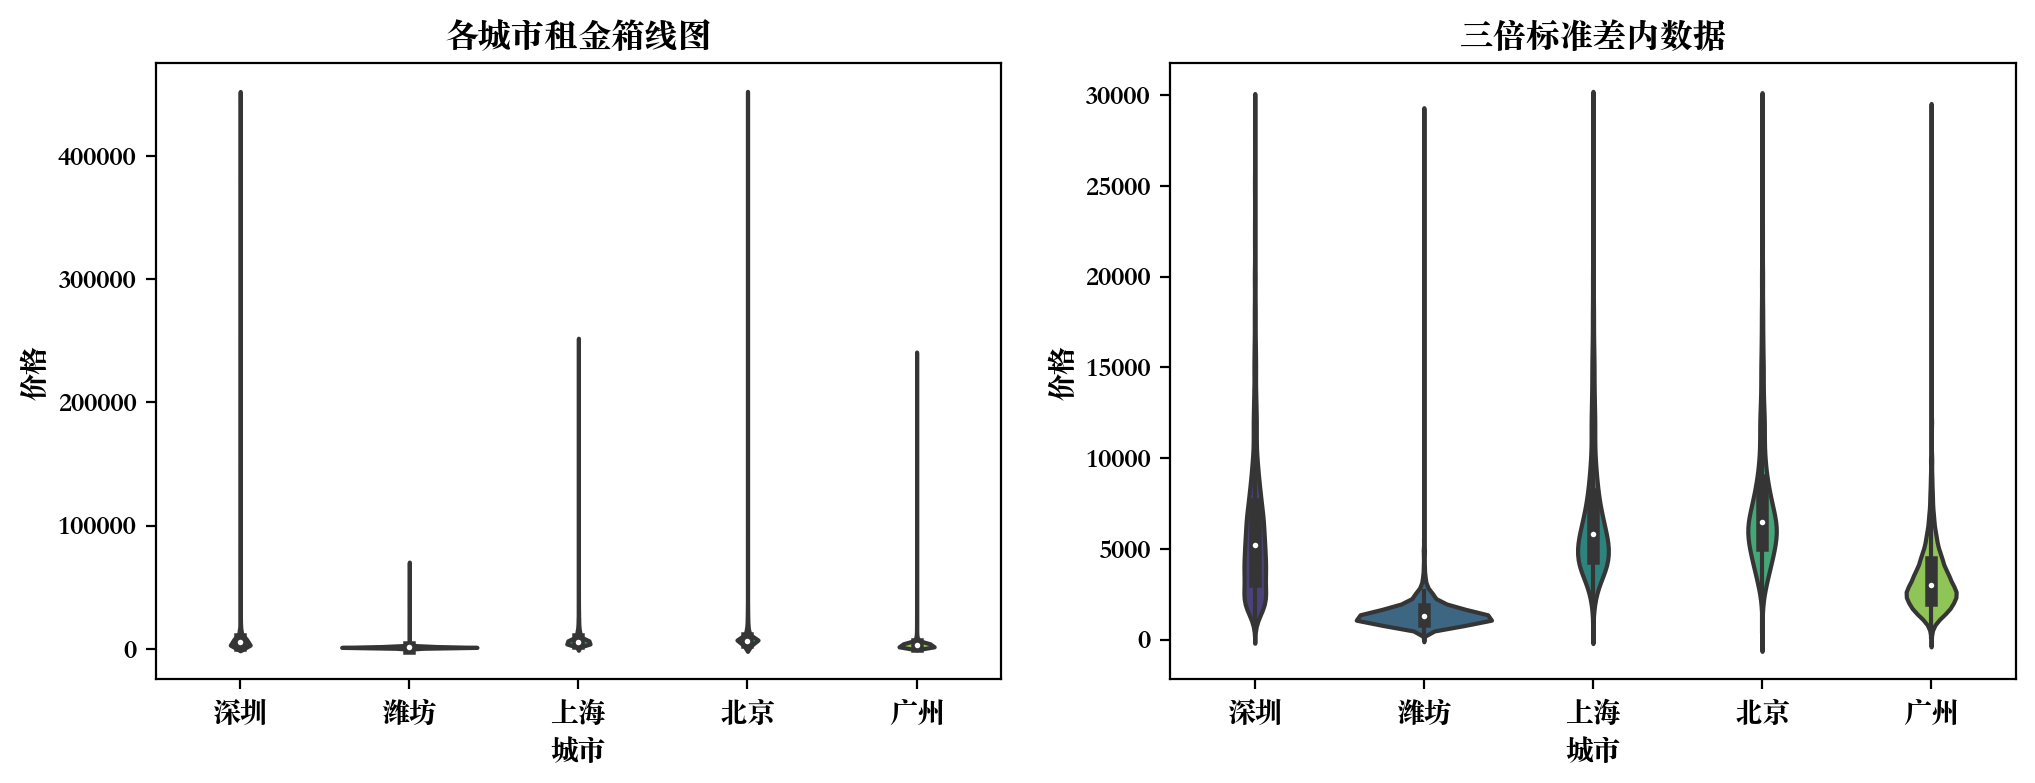

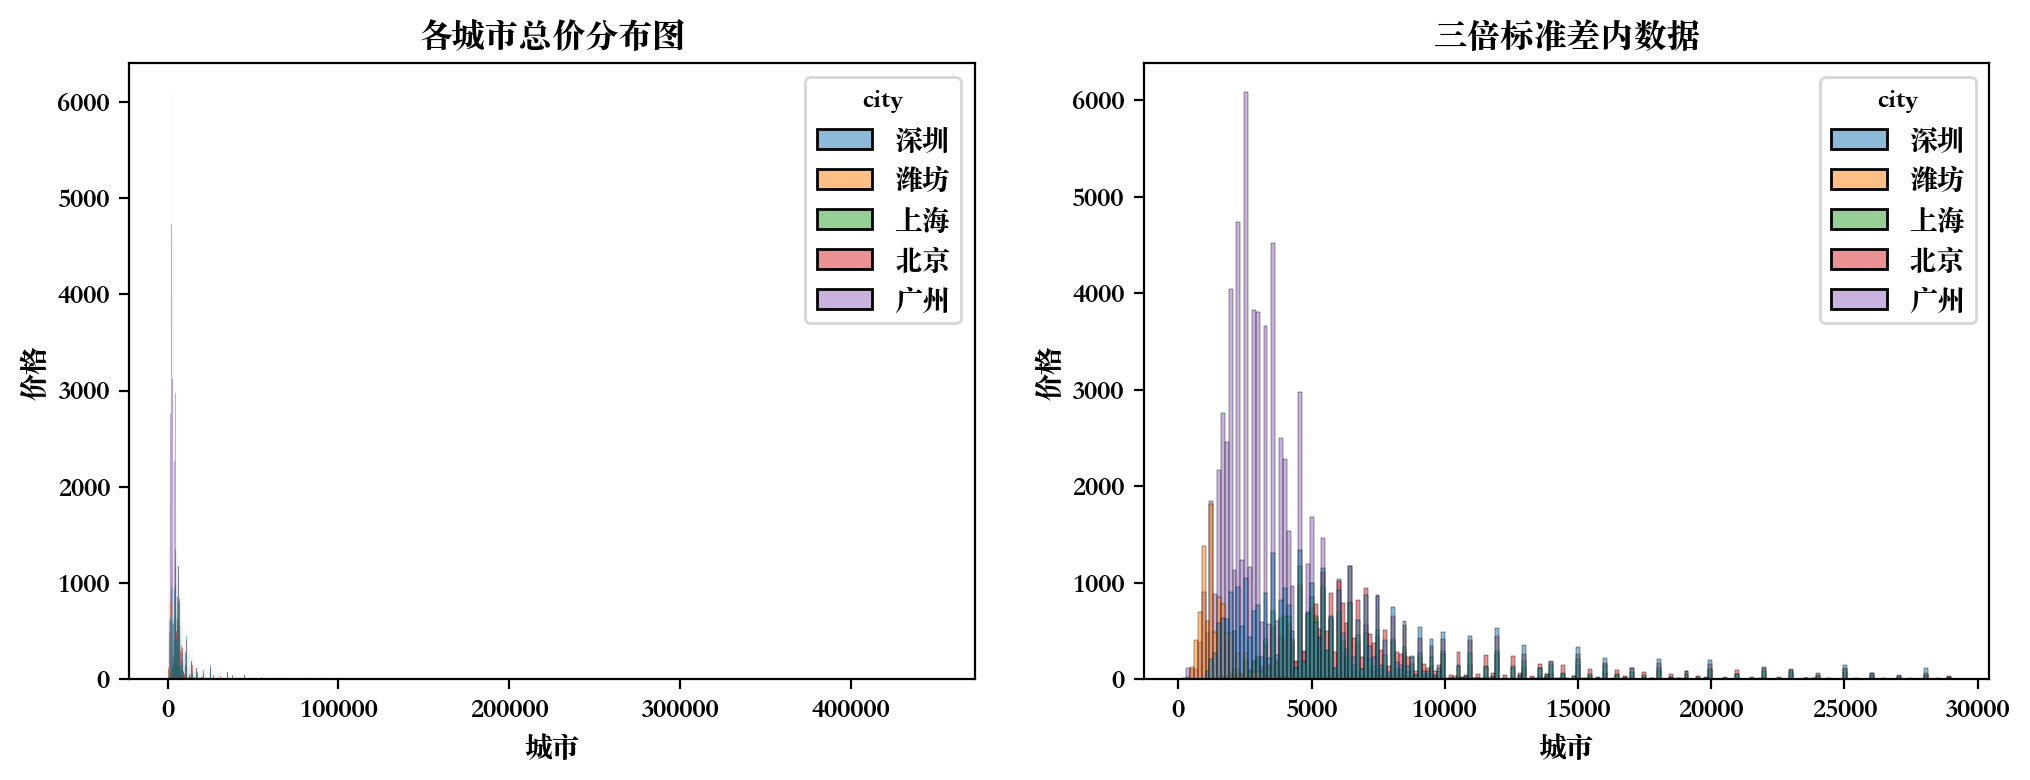

In [7]:
mean = price_df["price"].mean()
std = price_df["price"].std()
upper_border = mean + 3 * std

print(price_df["price"].skew())

cities = list(price_df["city"].drop_duplicates())

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4),dpi=200)
g = sns.violinplot(
    x="city", y="price", data=price_df, palette="viridis", ax=ax1
)
g.set_title("各城市租金箱线图")
g.set_xlabel("城市")
g.set_ylabel("价格")
g = sns.violinplot(
    x="city",
    y="price",
    data=price_df[price_df["price"] < upper_border],
    palette="viridis",
    ax=ax2,
)
g.set_title("三倍标准差内数据")
g.set_xlabel("城市")
g.set_ylabel("价格")
plt.show()

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4),dpi=200)
g = sns.histplot(x="price", hue="city", data=price_df, ax=ax1)
g.set_title(
    "各城市总价分布图"
)
g.set_xlabel("城市")
g.set_ylabel("价格")
g = sns.histplot(
    x="price",
    hue="city",
    data=price_df[price_df["price"] < upper_border],
    ax=ax2,
)
g.set_title("三倍标准差内数据")
g.set_xlabel("城市")
g.set_ylabel("价格")
plt.show()


可以看到, 在不去除异常值的情况下, 小提琴图中有大量超出whisker的1.5倍IQR的数值, 平
均总价分布histrogram中也显示, 租房价格极高的房源极少, 造成明显的长尾分布.

具体到城市的区别, 北京, 上海和深圳的分布比较类似, 分布上更偏向价格更高的部分; 而广州和潍坊的租金相对更加低廉.

### 租房单价比较

与上面租房价格的比较流程相同. 首先展示五大城市的租房价格统计数据.

In [8]:
unit_price_df = pd.DataFrame(df, columns=["city", "unit_price"])
mean = unit_price_df["unit_price"].mean()
std = unit_price_df["unit_price"].std()
upper_border = mean + 3 * std

for city in cities:
    print(f"{city}:")
    print(f"\t全部数据统计信息:")
    display(
        unit_price_df.loc[unit_price_df["city"] == city]
        .agg({"unit_price": ["mean", "max", "min", "median"]})
        .rename({"mean": "平均值", "max": "最大值", "min": "最小值", "median": "中位数"})
        .rename({"unit_price": "均价"},axis=1),
    )

    print(f"\t三倍标准差内数据统计信息:")
    display(
        unit_price_df.loc[
            (unit_price_df["city"] == city)
            & (unit_price_df["unit_price"] < upper_border)
        ]
        .agg({"unit_price": ["mean", "max", "min", "median"]})
        .rename({"mean": "平均值", "max": "最大值", "min": "最小值", "median": "中位数"})
        .rename({"unit_price": "均价"},axis=1),
    )


深圳:
	全部数据统计信息:


,均价
平均值,113.498366
最大值,933.330000
最小值,1.000000
中位数,99.430000


	三倍标准差内数据统计信息:


,均价
平均值,103.867782
最大值,238.100000
最小值,1.000000
中位数,96.150000


潍坊:
	全部数据统计信息:


,均价
平均值,15.308537
最大值,283.330000
最小值,0.850000
中位数,13.950000


	三倍标准差内数据统计信息:


,均价
平均值,15.279518
最大值,85.000000
最小值,0.850000
中位数,13.950000


上海:
	全部数据统计信息:


,均价
平均值,101.186555
最大值,670.730000
最小值,8.300000
中位数,92.935000


	三倍标准差内数据统计信息:


,均价
平均值,98.275846
最大值,238.120000
最小值,8.300000
中位数,92.200000


北京:
	全部数据统计信息:


,均价
平均值,100.735278
最大值,997.010000
最小值,0.020000
中位数,96.845000


	三倍标准差内数据统计信息:


,均价
平均值,99.550303
最大值,238.100000
最小值,0.020000
中位数,96.550000


广州:
	全部数据统计信息:


,均价
平均值,52.231509
最大值,909.090000
最小值,0.020000
中位数,45.750000


	三倍标准差内数据统计信息:


,均价
平均值,51.554925
最大值,238.100000
最小值,0.020000
中位数,45.710000


分别绘制全部数据和去除三倍标准差外数据的图进行比较.

In [9]:
print(unit_price_df['unit_price'].skew())
print(unit_price_df[unit_price_df['unit_price']<upper_border].skew())

1.8721898687998964
unit_price    0.928964
dtype: float64


通过上面的skewness可以看到, 即便在不去除三倍标准差外数据的情况下, 单位面积租金也比租
金总价更贴近正态分布. 

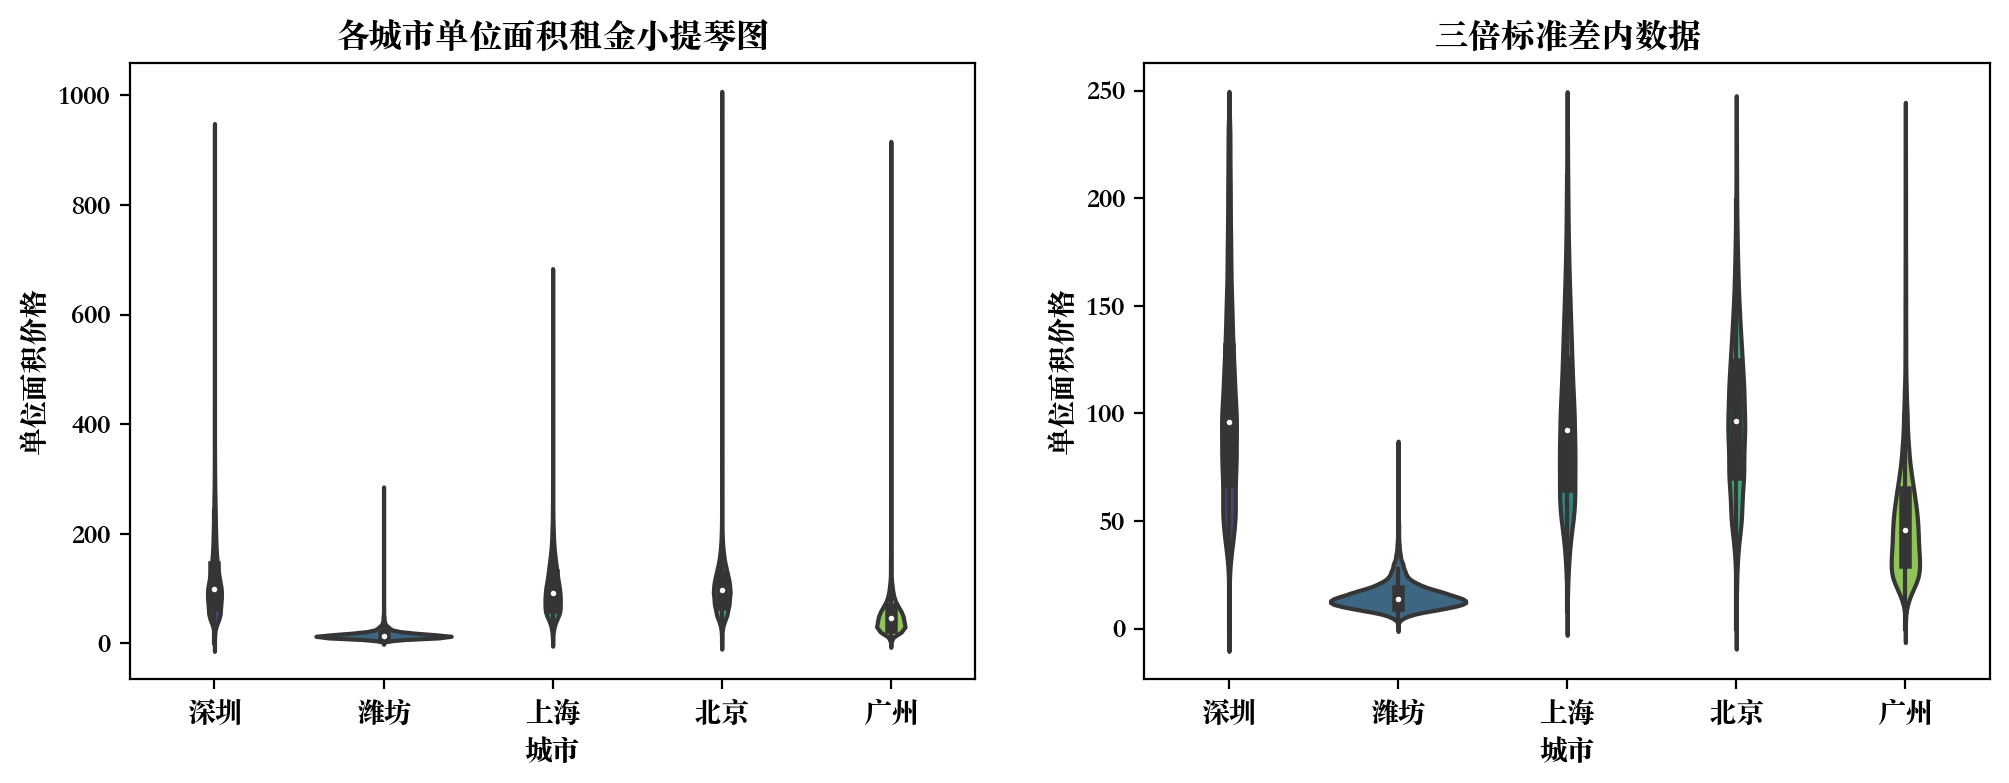

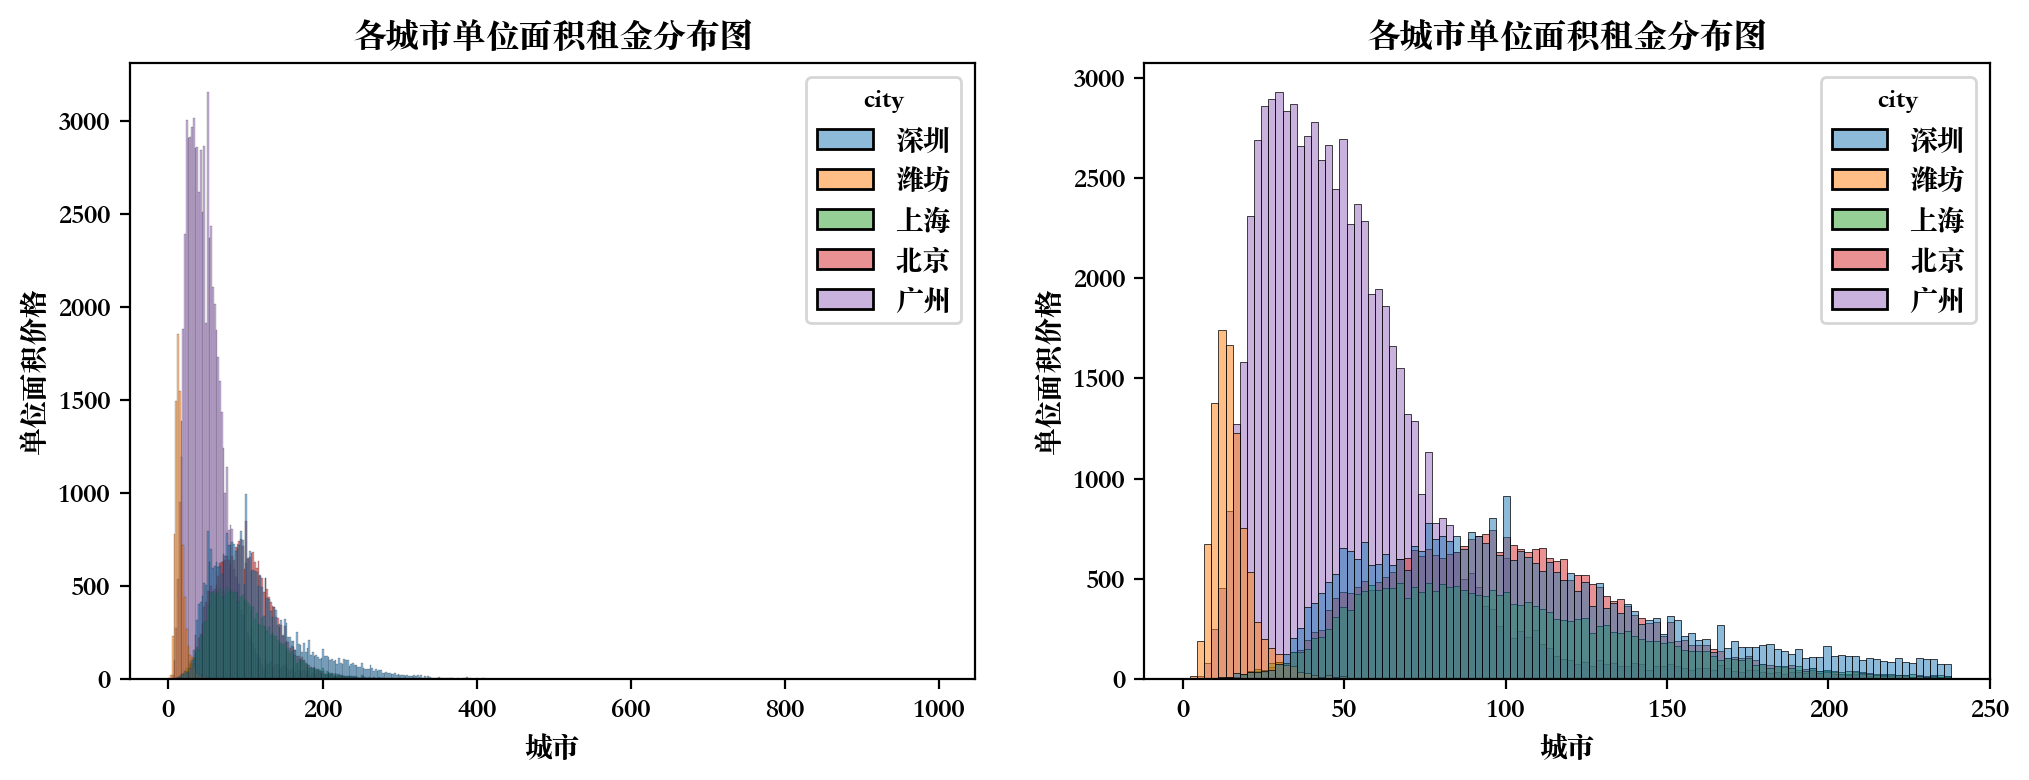

In [10]:
mean = unit_price_df["unit_price"].mean()
std = unit_price_df["unit_price"].std()
upper_border = mean + 3 * std

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4),dpi=200)

g = sns.violinplot(
    x="city", y="unit_price", data=unit_price_df, palette="viridis", ax=ax1
)
g.set_title("各城市单位面积租金小提琴图")
g.set_xlabel("城市")
g.set_ylabel("单位面积价格")

g = sns.violinplot(
    x="city",
    y="unit_price",
    data=unit_price_df[(unit_price_df["unit_price"] < upper_border)],
    palette="viridis",
    ax=ax2,
)
g.set_title("三倍标准差内数据")
g.set_xlabel("城市")
g.set_ylabel("单位面积价格")
plt.show()

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4),dpi=200)
g = sns.histplot(x="unit_price", hue="city", data=unit_price_df, ax=ax1)
g.set_title("各城市单位面积租金分布图")
g.set_xlabel("城市")
g.set_ylabel("单位面积价格")

g = sns.histplot(
    x="unit_price",
    hue="city",
    data=unit_price_df[unit_price_df["unit_price"] < upper_border],
    ax=ax2,
)
g.set_title("各城市单位面积租金分布图")
g.set_xlabel("城市")
g.set_ylabel("单位面积价格")
plt.show()


可以看到, 北京, 上海和深圳的单位面积租金相对更高, 中位数, 均值, 四分之一数, 四分
之三数等均高于广州和潍坊. 北京和上海的分布非常相似. 广州和潍坊的单位面积租金更
低, 分布更集中.

## 分析和比较各居室房型

比较5个城市的一居, 二居和三局的租金均价, 最高价, 最低价和中位数等信息.

居室信息在Scrapy保存对SQLite数据库的时候就已经分离完毕, 在liverooms字段中, 因此只需直接提取即可进行比较.

In [11]:
# Get liverooms DataFrame
rooms_df = pd.DataFrame(df, columns=['city','rooms'])
mean = rooms_df['rooms'].mean()
std=rooms_df['rooms'].mean()
upper_border=mean+3*std

for city in cities:
    print(f"{city}:")
    print(f"\t全部数据统计信息:")
    display(
        rooms_df.loc[rooms_df["city"] == city]
        .agg({"rooms": ["mean", "max", "min", "median"]})
        .rename({"mean": "平均值", "max": "最大值", "min": "最小值", "median": "中位数"})
        .rename({"rooms": "居室数量"},axis=1)
    )
    print(f"\t三倍标准差内数据统计信息:")
    display(
        rooms_df.loc[
            (rooms_df["city"] == city) & (rooms_df["rooms"] < upper_border)
        ]
        .agg({"rooms": ["mean", "max", "min", "median"]})
        .rename({"mean": "平均值", "max": "最大值", "min": "最小值", "median": "中位数"})
        .rename({"rooms": "居室数量"},axis=1),
    )


深圳:
	全部数据统计信息:


,居室数量
平均值,2.683549
最大值,15.000000
最小值,0.000000
中位数,3.000000


	三倍标准差内数据统计信息:


,居室数量
平均值,2.676047
最大值,9.000000
最小值,0.000000
中位数,3.000000


潍坊:
	全部数据统计信息:


,居室数量
平均值,2.452095
最大值,9.000000
最小值,0.000000
中位数,3.000000


	三倍标准差内数据统计信息:


,居室数量
平均值,2.452095
最大值,9.000000
最小值,0.000000
中位数,3.000000


上海:
	全部数据统计信息:


,居室数量
平均值,2.034813
最大值,10.000000
最小值,1.000000
中位数,2.000000


	三倍标准差内数据统计信息:


,居室数量
平均值,2.034439
最大值,9.000000
最小值,1.000000
中位数,2.000000


北京:
	全部数据统计信息:


,居室数量
平均值,2.116116
最大值,13.000000
最小值,0.000000
中位数,2.000000


	三倍标准差内数据统计信息:


,居室数量
平均值,2.114893
最大值,9.000000
最小值,0.000000
中位数,2.000000


广州:
	全部数据统计信息:


,居室数量
平均值,2.396116
最大值,20.000000
最小值,0.000000
中位数,2.000000


	三倍标准差内数据统计信息:


,居室数量
平均值,2.395654
最大值,9.000000
最小值,0.000000
中位数,2.000000


平均值方面, 可以看到相比于北京上海, 另外三各城市的居室数量平均要更高一些. 这也和
北京上海更高的单位面积价格相关.

最大值方面, 对全部数据, 广州的居室最大数量最大, 为20个, 其次是深圳; 对三倍标准差
内数据, 则均为9个.

最小值方面, 都是0个.

#### 各城市居室数量可视化分析

首先筛选出一居, 二居和三局的房型, 再绘制统计图进行比较.

In [12]:
filtered_rooms_df = rooms_df[rooms_df['rooms'].isin([1,2,3])]
display(filtered_rooms_df['rooms'].value_counts(ascending=False))

2    54499
3    52447
1    40745
Name: rooms, dtype: int64

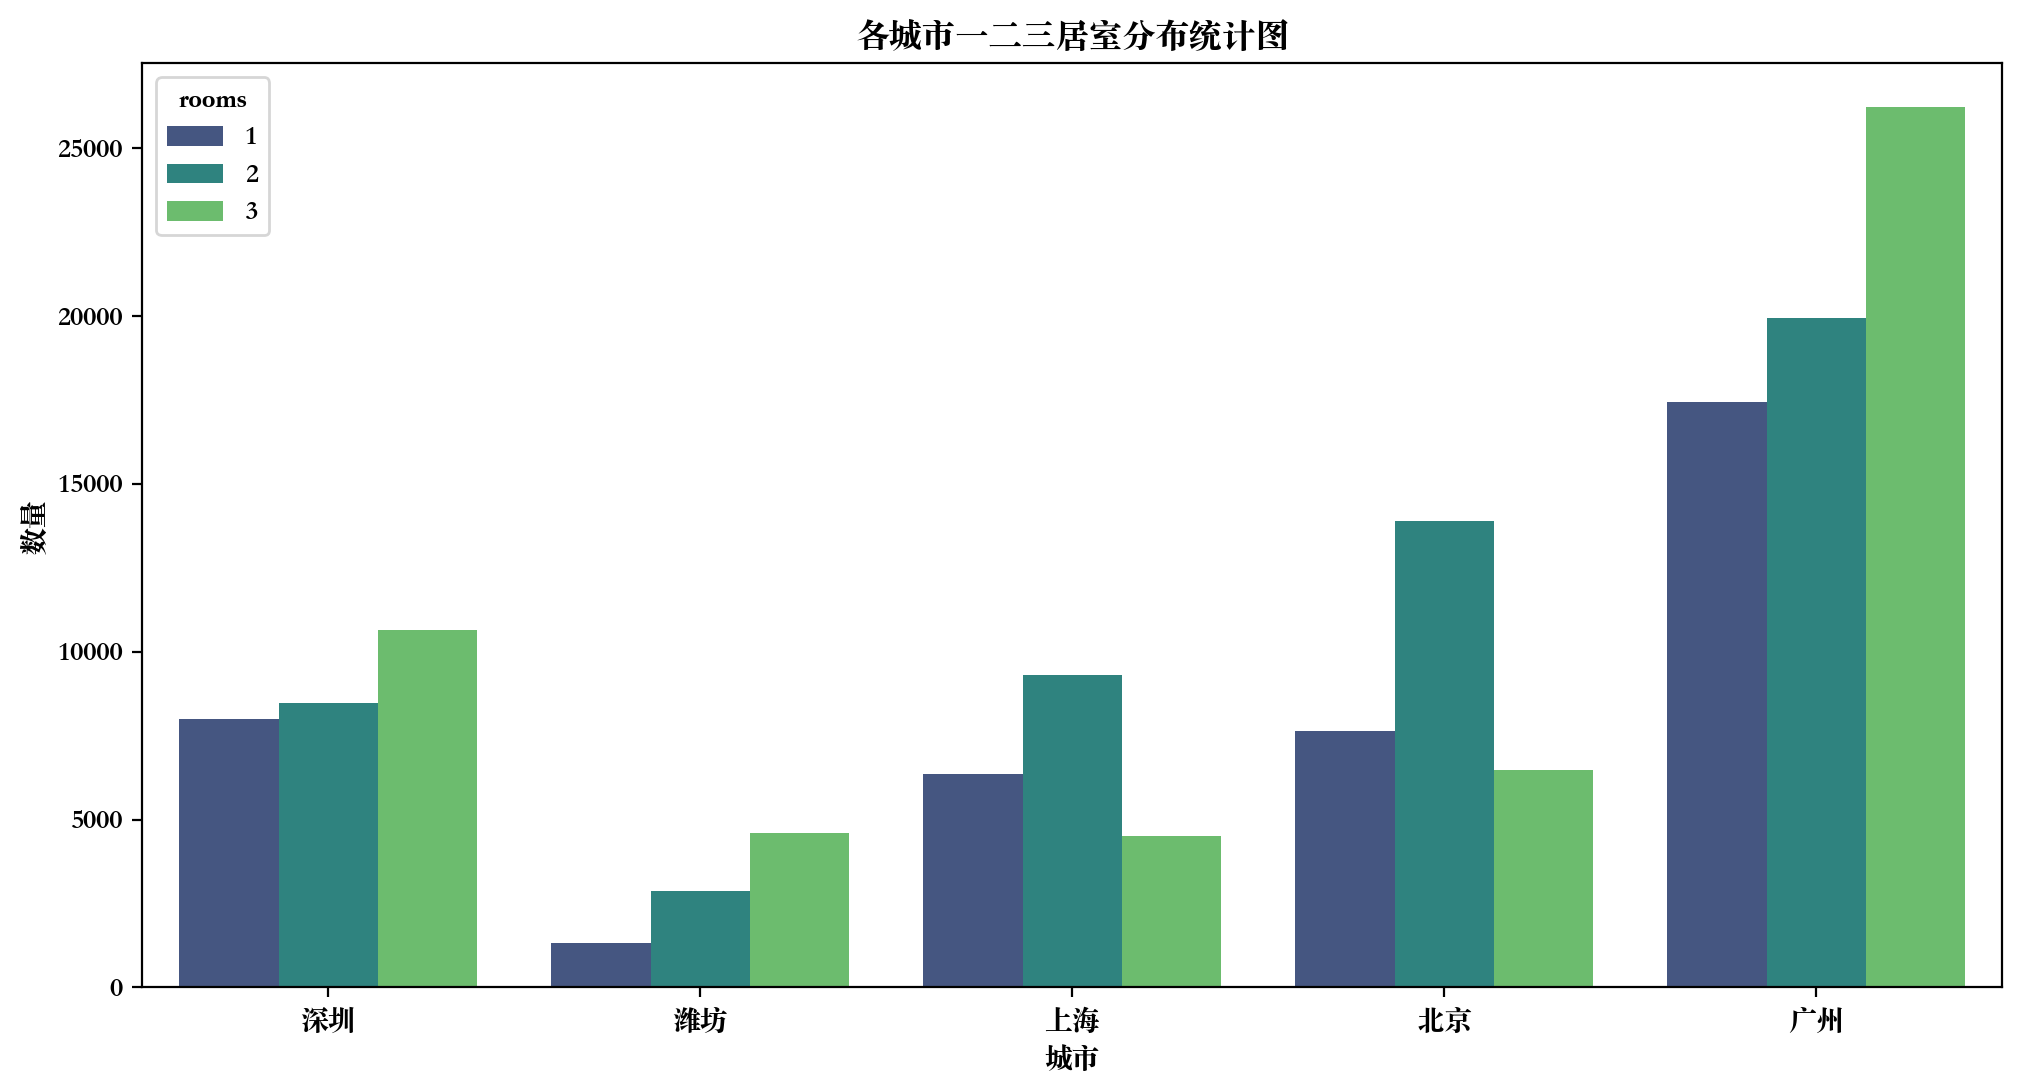

In [24]:
mean = filtered_rooms_df["rooms"].mean()
std = filtered_rooms_df["rooms"].std()
upper_border = mean + 3 * std

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
g = sns.countplot(
    x="city", data=filtered_rooms_df, hue="rooms", palette="viridis", ax=ax
)
g.set_title("各城市一二三居室分布统计图")
g.set_xlabel("城市")
g.set_ylabel("数量")
plt.show()


使用饼图来更方便的表示一二三居室在每个城市中的占比. 为了更方便的展示, 生成可交互饼图.

In [16]:
import plotly.express as px

figure = px.sunburst(
    filtered_rooms_df, values="rooms", path=["city",'rooms'], width=600, height=600
)

figure.update_traces(textinfo='label+percent parent')
figure.show()

上述代码生成的可交互饼图如下:
![pie](figures/rooms_pie.gif)

## 板块均价分析

对各个城市的板块均价进行统计分析. 计算和分析各个城市不同板块的均价, 并绘图分析.

首先对各城市行政区租售价格使用箱性图进行刻画. 为更好的突出平均值特征, 不显示箱性
图中的outliers, 且忽略三倍标准差之外的数据.

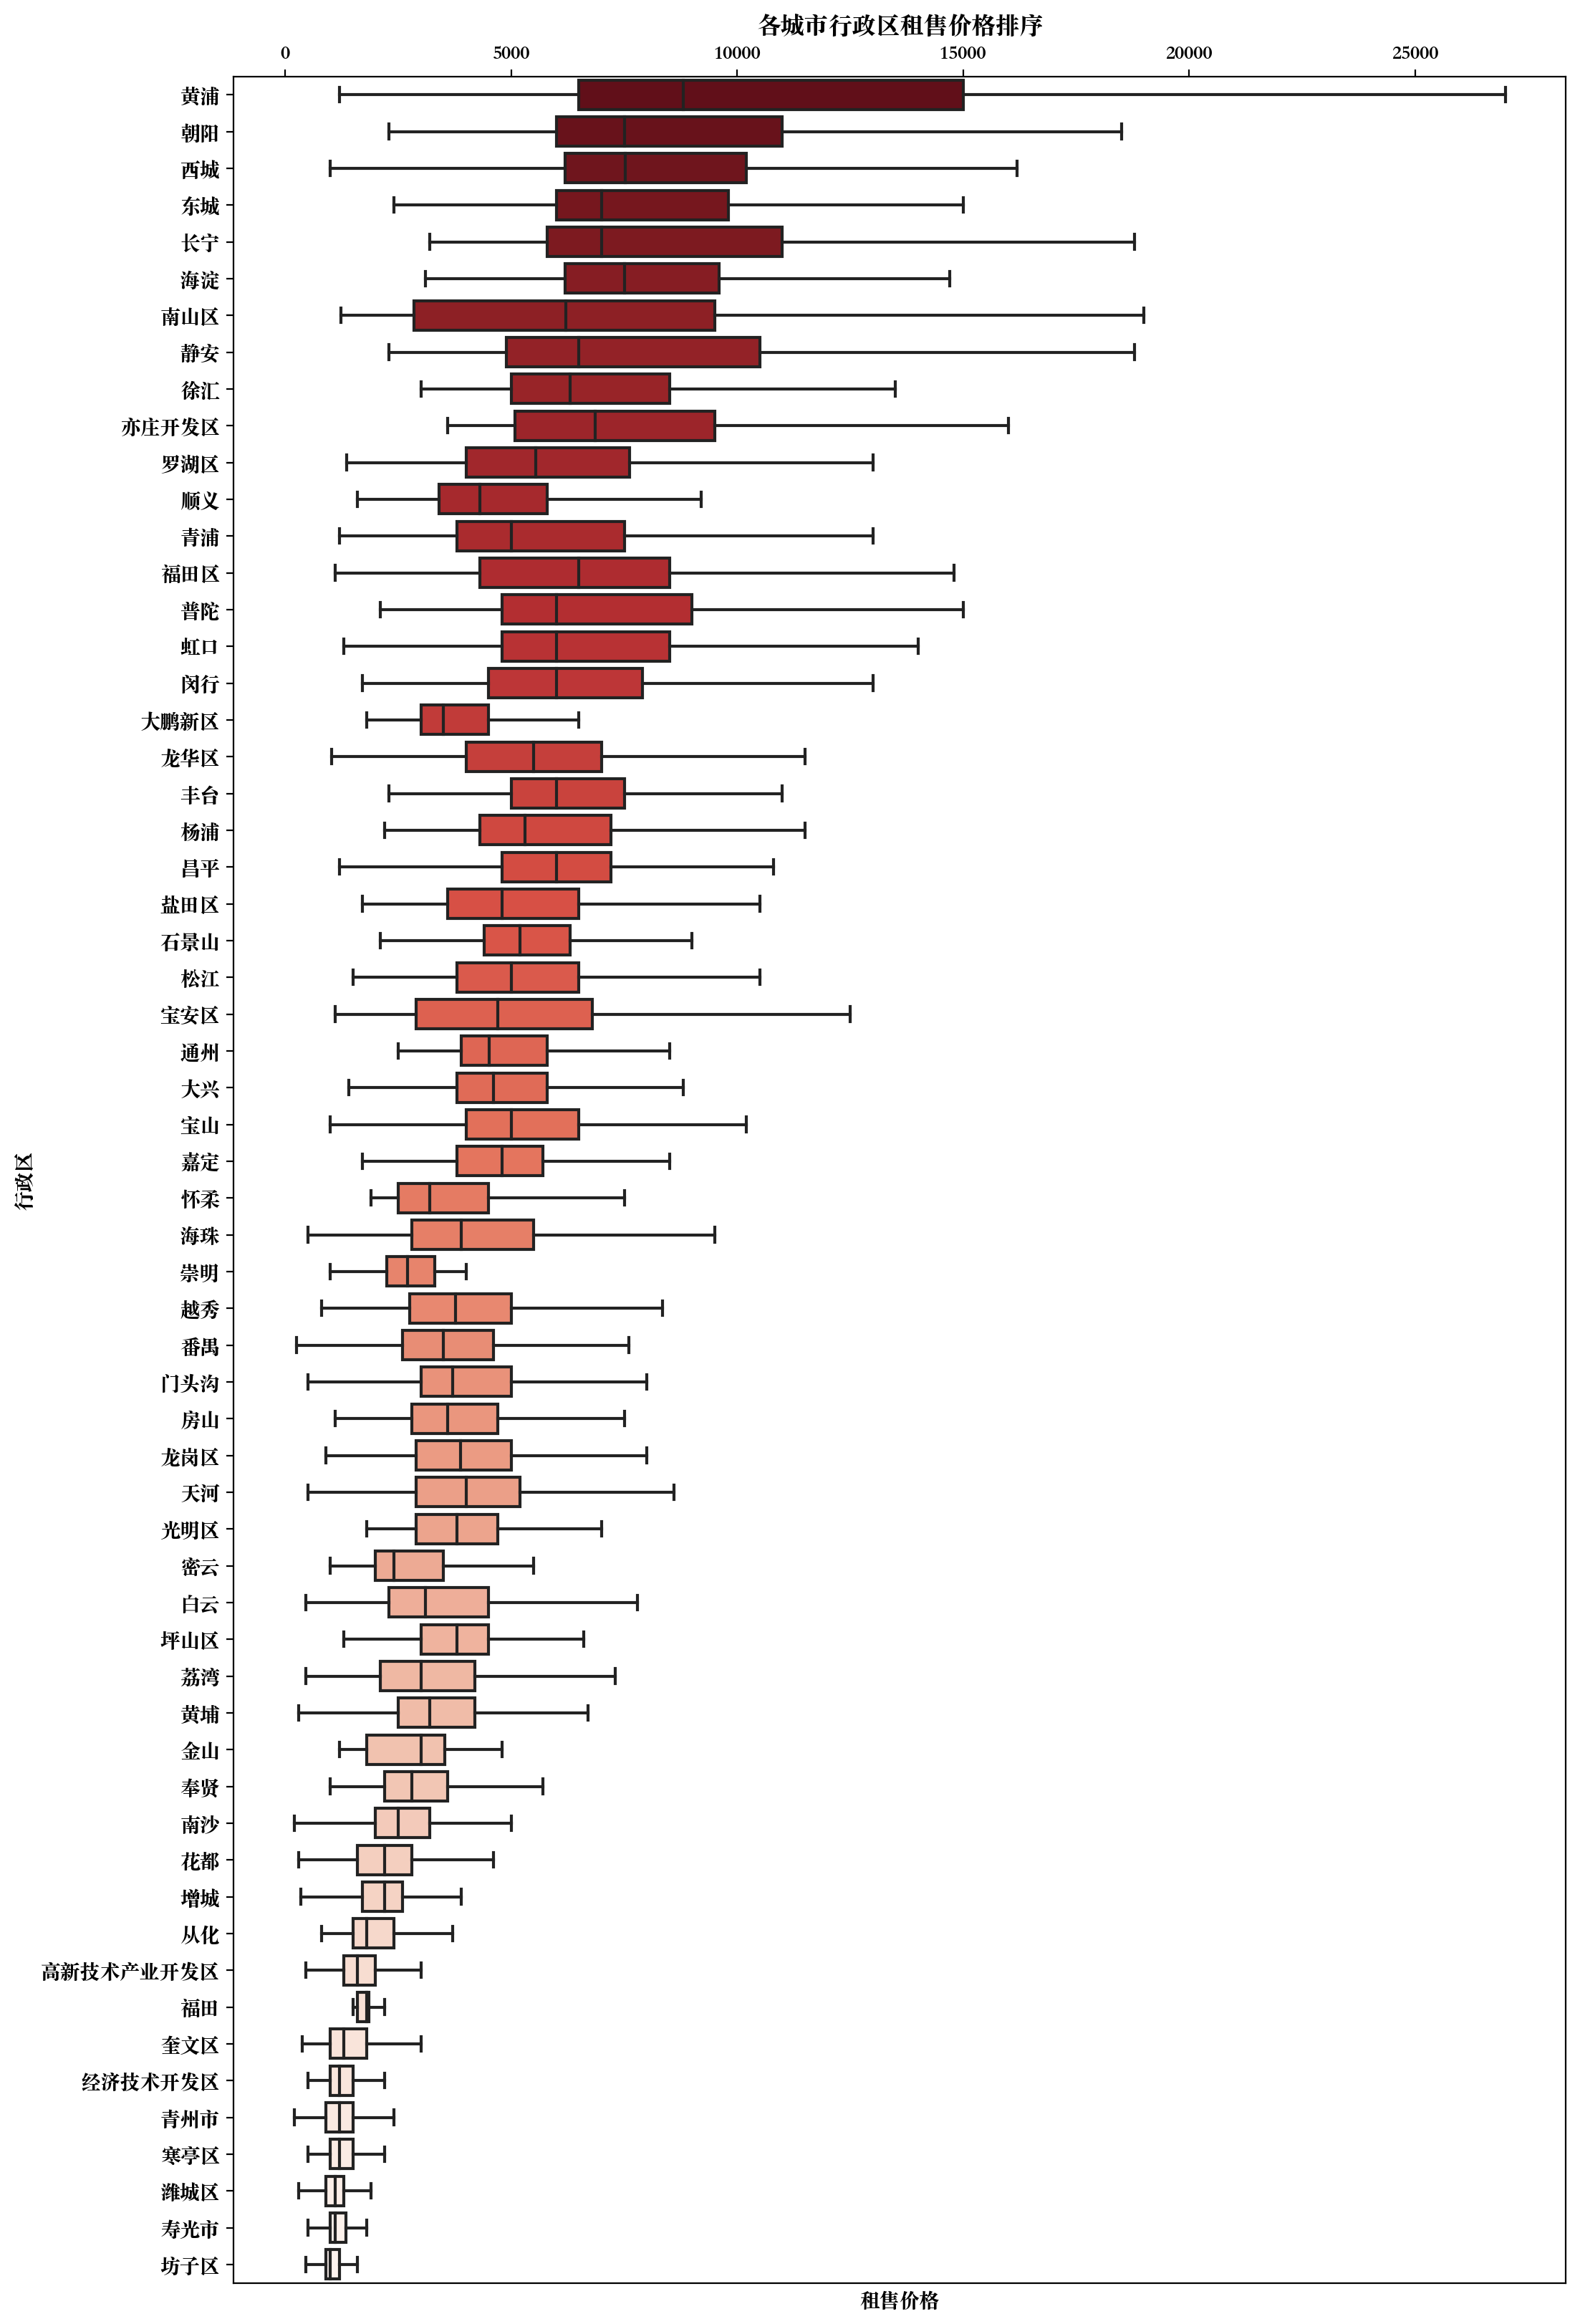

In [154]:
region_df = pd.DataFrame(df, columns=["city", "region", "price"])
region_df = df.iloc[
    (-df.groupby("region")["price"].transform("mean")).argsort()
]

mean = region_df["price"].mean()
std = region_df["price"].std()
upper_border = mean + 3 * std

f, ax = plt.subplots(figsize=(12, 20), dpi=200)
g = sns.boxplot(
    y="region",
    x="price",
    data=region_df[region_df["price"] < upper_border],
    ax=ax,
    palette='Reds_r',
    showfliers=False,
)
g.xaxis.tick_top()
g.set_xlabel("租售价格")
g.set_ylabel("行政区")
g.set_title("各城市行政区租售价格排序")

plt.show()


下面绘制均值排布的柱状图.

,index,region,price
0,57,黄浦,13856.669130
1,27,朝阳,11036.890411
2,44,西城,10500.345990
3,0,东城,10277.008174
4,48,长宁,10184.131841


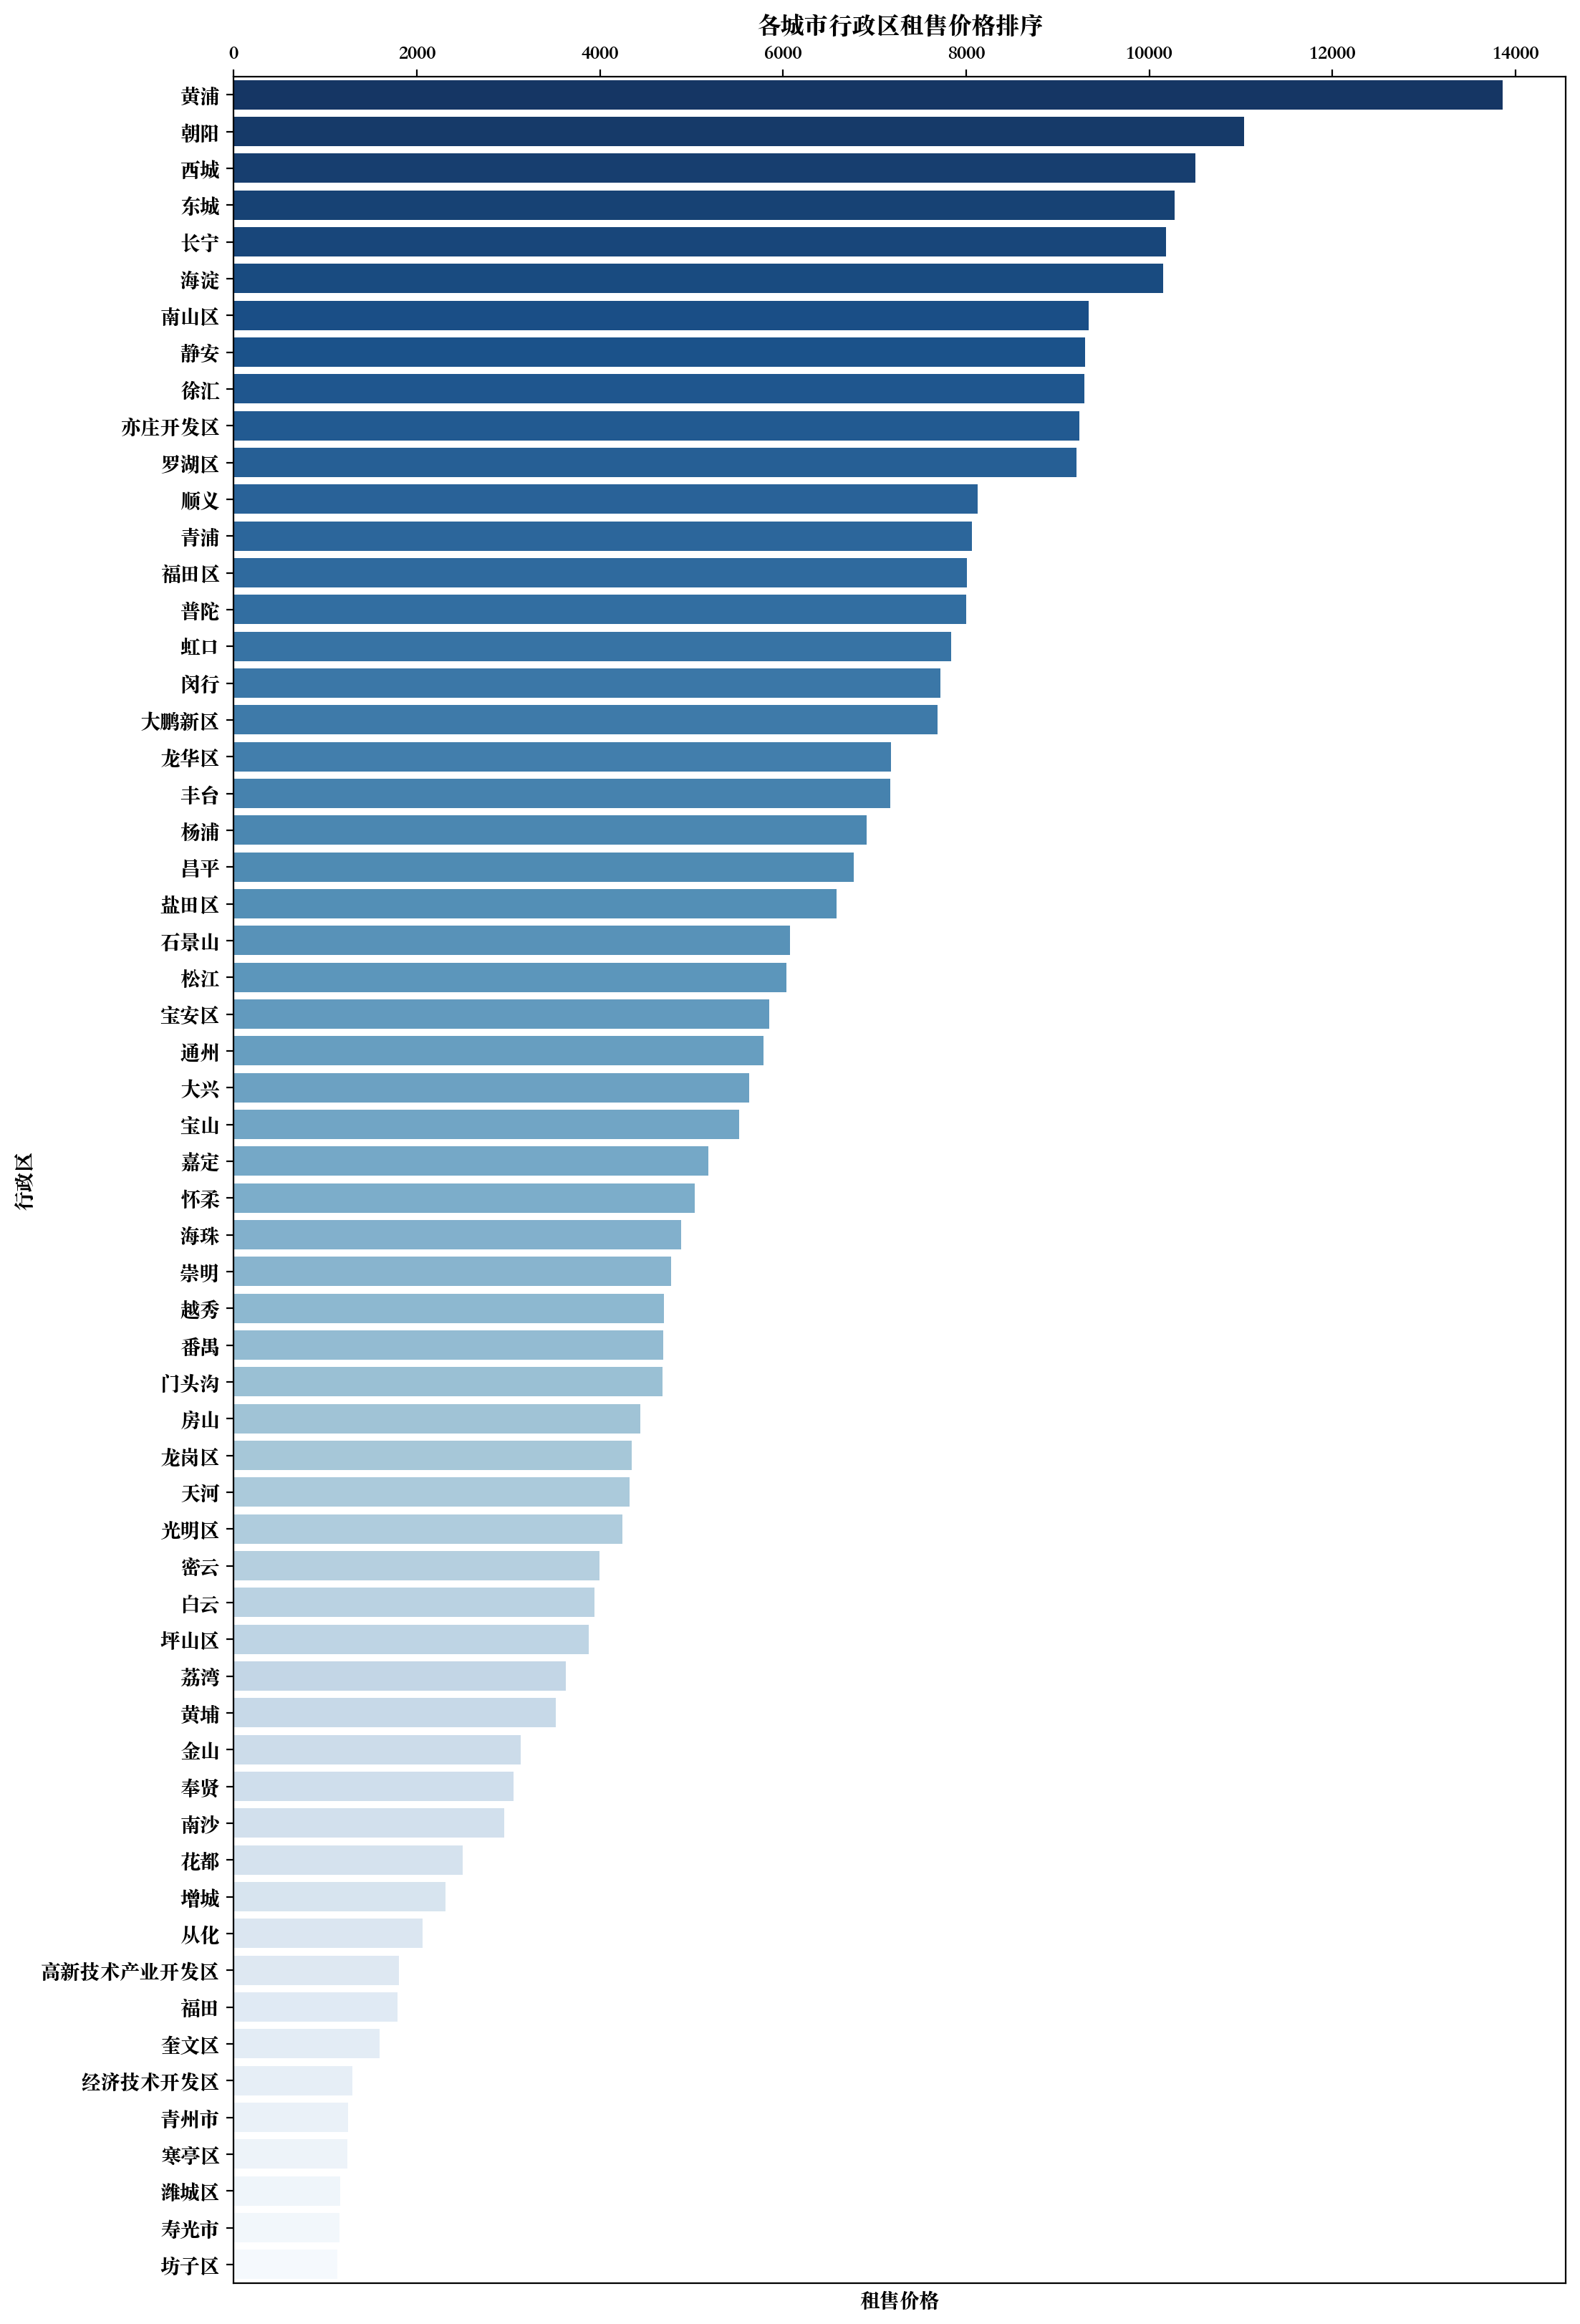

In [155]:
mean_region_df = pd.DataFrame(
    region_df.groupby("region", as_index=False)["price"]
    .mean()
    .sort_values(by='price',ascending=False)
    .reset_index()
)
display(mean_region_df.head())


f, ax = plt.subplots(figsize=(12, 20), dpi=200)
g = sns.barplot(mean_region_df, y="region", x="price", palette="Blues_r", ax=ax)
g.xaxis.tick_top()
g.set_xlabel("租售价格")
g.set_ylabel("行政区")
g.set_title("各城市行政区租售价格排序")
plt.show()

上海的黄埔的平均租价明显高于其他行政区划; 排在前列的均是北京上海的行政区, 其次是
深圳的行政区. 排在最后的是潍坊的行政区划, 这与五个城市的经济发展水平相吻合.